# Hackathon 6

Topics:
- Techniques for dimension expansion
    - Transpose convolutions
    - Sub-pixel convolutions
    - ProgressiveGAN upscaling
- Autoencoding
    - Sparse autoencoders
    - De-noising autoencoders

This is all setup in a IPython notebook so you can run any code you want to experiment with. Feel free to edit any cell, or add some to run your own code.

In [1]:
# We'll start with our library imports...
from __future__ import print_function

import os  # to work with file paths

import tensorflow as tf         # to specify and run computation graphs
import numpy as np              # for numerical operations taking place outside of the TF graph
import matplotlib.pyplot as plt # to draw plots

mnist_dir = '/work/cse496dl/shared/hackathon/03/mnist/'
cifar_dir = '/work/cse496dl/shared/hackathon/05/'

In [2]:
# extract our dataset, MNIST
train_data = np.load(mnist_dir + 'mnist_train_images.npy')
train_data = np.reshape(train_data, [-1, 28, 28, 1])
test_data = np.load(mnist_dir + 'mnist_test_images.npy')
test_data = np.reshape(test_data, [-1, 28, 28, 1])

### Techniques for dimension expansion

Generally we compress high dimensional representations into lower dimensional ones. Now, we're going to study ways of going from lower dimensional to higher. For this, we're going to define a function `upscale_block` in three different ways.

#### Transpose convolutions

Although we can reverse linear transformations very easily, images are less straightforward to upscale. Aside from naive, classical techniques for upscaling, we can learn to increase the size of images with transpose convolutions. They are sometimes called "deconvolutions" because they're the inverse operation of the convolution, but it is actually the transpose (gradient) of conv2d rather than an actual deconvolution. Transpose convolutions are implemented by [tf.layers.conv2d_transpose](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d_transpose).

In [3]:
# Upscales by take summary of image, and try to reconstruct what data was previously there
def upscale_block(x, scale=2):
    """ conv2d_transpose """
    # We scale up dimensions by 2, so 4x4 goes to 8x8
    # the 3,3 specifies the number of channels (not just rgb), filter size
    return tf.layers.conv2d_transpose(x, 3, 3, strides=(scale, scale), padding='same', activation=tf.nn.relu)

# Define graph
tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])
# Run upscale block on input x
up_x = upscale_block(x)
print(up_x)

# This counts the number of trainable parameters
num_params = np.sum([np.prod(v.get_shape().as_list()) for v in tf.trainable_variables()])
print('Parameters: ' + str(num_params))

W1012 12:20:11.221431 47958307618944 deprecation.py:323] From <ipython-input-3-7625a3dc34ca>:6: conv2d_transpose (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2DTranspose` instead.
W1012 12:20:11.240186 47958307618944 deprecation.py:506] From /util/opt/anaconda/deployed-conda-envs/packages/tensorflow/envs/tensorflow-1.14.0-py36/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Tensor("conv2d_transpose/Relu:0", shape=(?, 64, 64, 3), dtype=float32)
Parameters: 84


#### Sub-pixel convolutions

Another approach is called the sub-pixel convolution, which does a convolution with many channels, and then re-orders the data into the height and width dimensions from the channels dimension:

<img src="https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/03a5b2aac53443e6078f0f63b35d4f95d6d54c5d/2-Figure1-1.png">

(Image sourced from [Real-Time Single Image and Video Super-Resolution Using an Efficient Sub-Pixel Convolutional Neural Network](https://arxiv.org/abs/1609.05158))

In [4]:
# This does regular convolution on input to recognize pattersn
# Uses many more channels so it can find small details
# We interpret each c hannel as pixels of image spread out
# Not really understanding how this works...

# It is very powerful, but requires many more parameters
def upscale_block(x, scale=2):
    """ [Sub-Pixel Convolution](https://arxiv.org/abs/1609.05158) """
    # c is number of channels
    n, w, h, c = x.get_shape().as_list()
    # Make sure height and width of image are same after convolution here
    # Number of filters is number of channels
    # Because we want to double height and width we take 1 channel and turn it into 4
    # If input image 32x32 we get out 64,64
    
    # Tile out pixels (if we have 4 filters arrange as below), spaced out
    # [1 2 1 2 ...]
    # [3 4 3 4 ...]
    # [...]
    x = tf.layers.conv2d(x, c * scale ** 2, (3, 3), activation=tf.nn.relu, padding='same')
    # (3,3) is stride
    
    # This does the rearrangement
    output = tf.depth_to_space(x, scale)
    return output
    
tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])
x_up = upscale_block(x)
print(x_up)

# Note we get many more parameters because here we have 4 times as many channels as we had in
num_params = np.sum([np.prod(v.get_shape().as_list()) for v in tf.trainable_variables()])
print('Parameters: ' + str(num_params))

W1012 12:20:13.022919 47958307618944 deprecation.py:323] From <ipython-input-4-07e0397d2f78>:20: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.


Tensor("DepthToSpace:0", shape=(?, 64, 64, 3), dtype=float32)
Parameters: 336


#### ProgressiveGAN upscaling

Finally, one technique that's recently found massive success in Nvidia's ProgressiveGAN used to generate high-resolution fake celebrity faces:

<img src="https://i2.wp.com/robotnyheter.se/wp-content/uploads/2018/01/Nvidia_GAN_ansikten.jpg?w=1561" width="70%">

None of these are real photos, they've all been upsampled from Gaussian noise with this technique

In [5]:
def upscale_block(x, scale=2):
    """ similar to the upsampling used in [ProgressiveGAN](https://arxiv.org/pdf/1710.10196.pdf) """
    n, w, h, c = x.get_shape().as_list()
    # This is a bilinear upscale (older algorithm)
    # Problem is you of course get a lot of fuzziness in images
    up_x = tf.image.resize_nearest_neighbor(x, [scale*h, scale*w])
    # Here the convolution is used to sharpen it
    output = tf.layers.conv2d(up_x, 3, 3, padding='same', activation=tf.nn.relu)
    return output

tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])
x_up = upscale_block(x)
print(x_up)

# Note here we are back down to 84 parameters as we only kept 3 channels without creating new ones
num_params = np.sum([np.prod(v.get_shape().as_list()) for v in tf.trainable_variables()])
print('Parameters: ' + str(num_params))

Tensor("conv2d/Relu:0", shape=(?, 64, 64, 3), dtype=float32)
Parameters: 84


### Autoencoding

Generally, autoencoding is learning "a complicated identity function". This makes it a form of unsupervised learning, which doesn't require data to be explicitly labeled, but instead looks for patterns and trends in data. Typically the complication is to bottleneck the size of the representation, but can also be more varied. We'll look at code for sparse autoencoders and de-noising autoencoders.

First we'll define some preliminaries that we'll use in both architectures:

In [6]:
def upscale_block(x, scale=2):
    """transpose convolution upscale"""
    # Here we upscale by factor of 2
    return tf.layers.conv2d_transpose(x, 1, 3, strides=(scale, scale), padding='same', activation=tf.nn.relu)

# use convolution for downscaling
def downscale_block(x, scale=2):
    n, h, w, c = x.get_shape().as_list()
    # Here we downscale by factor of 2
    return tf.layers.conv2d(x, np.floor(c * 1.25), 3, strides=scale, padding='same')

def autoencoder_network(x, code_size=100):
    """This network assumes [?, 28, 28, ?] shaped input"""
    # encoder
    encoder_14 = downscale_block(x)
    encoder_7 = downscale_block(encoder_14)
    flatten_dim = np.prod(encoder_7.get_shape().as_list()[1:])
    flat = tf.reshape(encoder_7, [-1, flatten_dim])
    # code
    code = tf.layers.dense(flat, code_size, activation=tf.nn.relu)
    # decoder
    # 49 neurons used as I need to end up with 28x28x1 output (not entirely sure...)
    # 28 = (7+7)*2
    hidden_decoder = tf.layers.dense(code, 49, activation=tf.nn.elu)
    decoder_7 = tf.reshape(hidden_decoder, [-1, 7, 7, 1])
    decoder_14 = upscale_block(decoder_7)
    output = upscale_block(decoder_14)
    return code, output

#### Sparse autoenoding

Although we bottleneck the representation in normal autoencoding by reducing the dimensionality, sparse autoencoders can actually increase it, but restrict it to be sparsely activated with L1 regularization using [tf.norm](https://www.tensorflow.org/api_docs/python/tf/norm) or KL-divergence. This has the effect of only having non-zero values in a few dimensions, effectively bottlenecking each representation, but giving a greater variety of dimensions to choose to be used.

In [7]:
# This uses L1 regularizer penalizes for every non-zero vector
# This means we want to use as few indices in vector as possible

# It does not bottleneck amount of data that can pass through though, which the standard auto-encoder does

# set hyperparameters
sparsity_weight = 5e-4 # 5e-3 made output all zero
code_size = 100
EPOCHS = 1
BATCH_SIZE = 64

# define graph
tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape=[None, 28, 28, 1])
# Defined in autoencoder_network above
code, outputs = autoencoder_network(x, code_size)
# Code would be the output of the autoencoder if we were doing transfer learning, as this is most compressed

# just for fun count number of parameters in network
num_params = np.sum([np.prod(v.get_shape().as_list()) for v in tf.trainable_variables()])
print('Parameters: ' + str(num_params))

# calculate loss
sparsity_loss = tf.norm(code, ord=1, axis=1) # Calculates L1 norm
reconstruction_loss = tf.reduce_mean(tf.square(outputs - x)) # Mean Square Error
total_loss = reconstruction_loss + sparsity_weight * sparsity_loss # total loss including both

# setup optimizer
optimizer = tf.train.AdamOptimizer()
train_op = optimizer.minimize(total_loss)

# train for an epoch
session = tf.Session()
session.run(tf.global_variables_initializer())
for epoch in range(EPOCHS):
    for i in range(train_data.shape[0] // BATCH_SIZE):
        batch_xs = train_data[i*BATCH_SIZE:(i+1)*BATCH_SIZE, :]
        session.run(train_op, {x: batch_xs})
print("Done!")

W1012 12:20:13.983966 47958307618944 deprecation.py:323] From <ipython-input-6-6675f071ffbc>:20: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.


Parameters: 9989
Done!


Code and Input
[[-0.          0.1010787  -0.         -0.          0.15245928 -0.
   0.930921    0.4564608  -0.         -0.         -0.         -0.
  -0.         -0.          0.16466914  0.1844     -0.         -0.
  -0.         -0.         -0.          0.5640377  -0.         -0.
  -0.         -0.         -0.         -0.         -0.          0.18913792
  -0.          0.5015242  -0.         -0.         -0.          0.23799577
   0.9350324  -0.         -0.         -0.         -0.         -0.
  -0.         -0.         -0.          0.37871265  0.41970932 -0.
   0.00424195  0.22550482 -0.         -0.         -0.         -0.
  -0.         -0.         -0.         -0.          0.88969725  0.700522
  -0.         -0.         -0.          0.28670785  0.63554966  0.7244459
   0.5065285  -0.         -0.         -0.          0.1729887  -0.
  -0.         -0.         -0.          0.35234573 -0.         -0.
  -0.         -0.         -0.         -0.         -0.         -0.
  -0.         -0.         -0.   

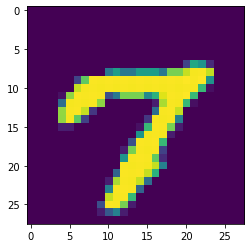

In [8]:
# Now run a test
idx = np.random.randint(test_data.shape[0])
# Run chosen data through autoencoder
x_out, code_out, output_out = session.run([x, code, outputs], {x: np.expand_dims(test_data[idx], axis=0)})

# Visualize code and output
print("Code and Input")
plt.imshow(np.squeeze(x_out))
print(code_out)
print("Number of nonzero code dimensions: {}/{}".format(np.count_nonzero(code_out), code_size))


Reconstruction


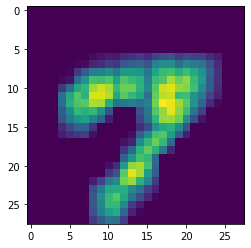

In [9]:
# Show reconstruction

# If reconstruction is terrible check code
# If it is all zeros then you have too high of a constraint on the L1 error
# Lowering this may help

# This is in a different cell from the last plt.imshow call to show 2 images at once
print("Reconstruction")
plt.imshow(np.squeeze(output_out))

# Very blocky as transfpose is not very great at resolution
# Using sharpening approches will likely provide better results in terms of resolution

# 

#### Denoising Autoencoder

Another way to force the an autoencoder to learn the features of data is to force it to map noisy, corrupted versions of the data back to the original. This is usually accomplished by manually adding noice (e.g., Gaussian), but may also be useful in real world settings.

The noise level could be scaled up as training proceeds to implement a form of [curriculum learning](https://ronan.collobert.com/pub/matos/2009_curriculum_icml.pdf).

In [10]:
# Works fundamentally different than sparse autoencoder
# Take clean image and add noise to it to distort it
# Then run through autoencoder and pass in distorted version and ask for original image
# It thus needs to learn to separate signal from noise

# hyperparameters
noise_level = 0.1
code_size = 40

# define graph
tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape=[None, 28, 28, 1])
# Add gaussian noise on top of input
x_noisy = x + noise_level * tf.random_normal(tf.shape(x))
# Pass noisy image into network
code, outputs = autoencoder_network(x_noisy, code_size=code_size)

# calculate loss
reconstruction_loss = tf.reduce_mean(tf.square(outputs - x)) # MSE
total_loss = reconstruction_loss # just for consistency even though there is only one term

# setup optimizer
optimizer = tf.train.AdamOptimizer()
train_op = optimizer.minimize(total_loss)

# train for an epoch and visualize
batch_size = 16
session = tf.Session()
session.run(tf.global_variables_initializer())
for epoch in range(2):
    for i in range(train_data.shape[0] // batch_size):
        batch_xs = train_data[i*batch_size:(i+1)*batch_size, :]
        session.run(train_op, {x: batch_xs})
print("Done!")

Done!


Input


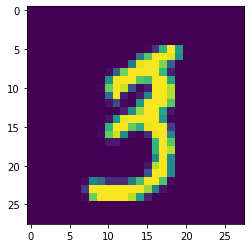

In [11]:
# run a test
idx = np.random.randint(test_data.shape[0])
x_out, noisy_x_out, code_out, output_out = session.run([x, x_noisy, code, outputs], {x: np.expand_dims(test_data[idx], axis=0)})
print("Input")
plt.imshow(np.squeeze(x_out))

Code and Noised Input
[[ 0.6735974   0.9724092   1.1182804   0.7309284   0.2113837   0.7636273
   1.1857438   1.394796    1.0736072   1.0191958  -0.          0.4363351
  -0.          0.56239116  0.6878202   0.5134084   0.7393745   1.3263414
   1.3831631   1.1395414   0.92428166 -0.          0.81724614  1.335417
   0.6488855   1.2148685   0.8766148   0.50705504  1.1391382   0.85937315
  -0.          0.15663268  0.9172243   0.6905645  -0.          1.4398689
   0.08250363  1.2056785   1.1510267   0.75959617]]
Number of nonzero code dimensions: 35/40


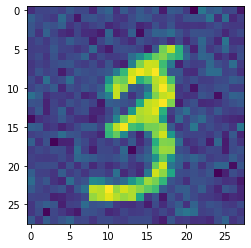

In [12]:
# show the noised input and code
plt.imshow(np.squeeze(noisy_x_out))
print("Code and Noised Input")
print(code_out)
print("Number of nonzero code dimensions: {}/{}".format(np.count_nonzero(code_out), code_size))

# Many less zeros in code as there is no restriction to specifically push them to zero
# If you add L1 regularization it may help, but it could be hard to balance hyperparameters with noise

Reconstruction


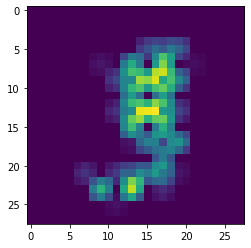

In [13]:
# Show reconstruction
# This has to be in a different cell from the last plt.imshow call to show 2 images at once
print("Reconstruction")
plt.imshow(np.squeeze(output_out))

Write code specifying an autoencoder with a code of shape `[None, 4, 4, 1]` with the provided input placeholder (corresponding to a color image like CIFAR-10). Specify a reasonable autoencoding loss function so that the given optimizer code runs.

In [15]:
# Don't need to train this
# Just create valid autoencoder so the lines below run correctly

tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])

# your code here

# Cut down to 16x16
encoder_1 = tf.compat.v1.layers.Conv2D(64, (5,5), 2, padding='same', name='encode_1', kernel_regularizer=tf.contrib.layers.l2_regularizer(0.1))(x)
# Cut down to 8x8
encoder_2 = tf.compat.v1.layers.Conv2D(32, (3,3), 2, padding='same', name='encode_2', kernel_regularizer=tf.contrib.layers.l2_regularizer(0.1))(encoder_1)
# Cut down to 4x4
encoder_3 = tf.compat.v1.layers.Conv2D(1, (3,3), 2, padding='same', name='encode_3', kernel_regularizer=tf.contrib.layers.l2_regularizer(0.1))(encoder_2)
# Flatten for use in dense layer code
flat = tf.reshape(encoder_3, [-1, 4,4,1], name='flat')
# Add code layer (16 neurons total from 4x4x1)
code = tf.compat.v1.layers.Dense( 16, activation=tf.nn.relu, name='code')(flat)
# Reshape back for convolutional layers
reshape_layer = tf.reshape(code, [-1, 4, 4, 1], name='decode_1')
# Upscale to 8x8
decoder_1 = tf.compat.v1.layers.Conv2DTranspose(1, (3,3), 2, padding='same', name='decode_1')(reshape_layer) 
# Upscale to 16x16
decoder_2 = tf.compat.v1.layers.Conv2DTranspose(32, (3,3), 2, padding='same', name='decode_2')(decoder_1)
# Upscale to 32x32
decoder_3 = tf.compat.v1.layers.Conv2DTranspose(64, (5,5), 2, padding='same', name='decode_3')(decoder_2)
# Calculate output
output = tf.compat.v1.layers.Conv2DTranspose(3, (3,3), 1, padding='same', name='output')(decoder_3)


# calculate loss
sparsity_weight = 5e-3
sparsity_loss = tf.norm(code, ord=1, axis=1)
reconstruction_loss = tf.reduce_mean(tf.square(output - x)) # Mean Square Error
loss = reconstruction_loss + sparsity_weight * sparsity_loss


# if your code works, this should have no problem
optimizer = tf.train.AdamOptimizer()
train_op = optimizer.minimize(loss)


### Coda

#### [Progressive GAN latent space interpolation on Youtube](https://youtu.be/XOxxPcy5Gr4?t=1m48s)

#### [How to Use t-SNE Effectively (distill.pub)](https://distill.pub/2016/misread-tsne/)